In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
from typing import List, Dict, Optional
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [ ]:
standings_df = pd.read_csv("2023_PL_standings.csv")
results_df = pd.read_csv("2023_matchday_results.csv",parse_dates=['fixture.date'])
home_df = pd.read_csv("2023_home_teams_stats.csv")
away_df = pd.read_csv("2023_away_teams_stats.csv")

In [ ]:
class FootballDataPreprocessor:
    """Handles all data preprocessing for football match data"""

    def __init__(self):
        self.processed_data = None
        self.feature_columns = None

    def load_and_clean_data(self, standings_path, results_path, home_path, away_path):
        """Load and clean all datasets"""
        print("Loading datasets...")

        # Load datasets
        self.standings_df = pd.read_csv(standings_path)
        self.results_df = pd.read_csv(results_path, parse_dates=['fixture.date'])
        self.home_df = pd.read_csv(home_path)
        self.away_df = pd.read_csv(away_path)

        print("Cleaning results data...")
        self._clean_results_data()

        print("Merging home and away data...")
        self._merge_home_away_data()

        print("Creating match statistics...")
        self._create_match_stats()

        return self.processed_data

    def _clean_results_data(self):
        """Clean the results dataset"""
        # Drop unnecessary columns
        self.results_df = self.results_df.drop(columns=['Unnamed: 0', 'teams.home.name', 'teams.away.name'], errors='ignore')

        # Create date column
        self.results_df['date'] = self.results_df['fixture.date'].apply(lambda x: x.date())
        self.results_df['date'] = pd.to_datetime(self.results_df['date'])

        # Create full_time result column
        conditions = [
            (self.results_df['teams.home.winner'] == True),
            (self.results_df['teams.home.winner'] == False),
            (self.results_df['teams.home.winner'].isnull())
        ]
        values = ['home', 'away', 'draw']
        self.results_df['full_time'] = np.select(conditions, values, default='draw')

        # Clean up columns
        self.results_df = self.results_df.drop(columns=['teams.home.winner', 'teams.away.winner'], errors='ignore')
        self.results_df = self.results_df.rename(columns={'fixture.id': 'fixture id'})

    def _merge_home_away_data(self):
        """Merge home and away datasets"""
        # Merge to get opponent information
        self.home_df = pd.merge(self.home_df, self.away_df[['fixture id', 'away team id', 'away team name']], on='fixture id', how='left')
        self.away_df = pd.merge(self.away_df, self.home_df[['fixture id', 'Home team id', 'Home team name']], on='fixture id', how='left')

        # Rename columns for consistency
        home_rename = {
            'Home team id': 'team id',
            'Home team name': 'team name',
            'away team id': 'opponent id',
            'away team name': 'opponent name'
        }

        away_rename = {
            'away team id': 'team id',
            'away team name': 'team name',
            'Home team id': 'opponent id',
            'Home team name': 'opponent name'
        }

        home_rename_df = self.home_df.rename(columns=home_rename)
        away_rename_df = self.away_df.rename(columns=away_rename)

        # Add home indicator
        home_rename_df['Home'] = 1
        away_rename_df['Home'] = 0

        # Concatenate datasets
        self.match_stats_df = pd.concat([home_rename_df, away_rename_df], ignore_index=True)

    def _create_match_stats(self):
        """Create comprehensive match statistics"""
        # Merge with results
        self.match_stats_df = pd.merge(
            self.match_stats_df,
            self.results_df[['fixture id', 'full_time', 'date']],
            on="fixture id",
            how='left'
        )

        # Fill missing values
        self.match_stats_df = self.match_stats_df.fillna(0)

        # Convert percentage columns
        if 'Ball Possession' in self.match_stats_df.columns:
            self.match_stats_df['Ball Possession'] = self.match_stats_df['Ball Possession'].astype(str).str.replace('%', '').astype(float)
        if 'Passes %' in self.match_stats_df.columns:
            self.match_stats_df['Passes %'] = self.match_stats_df['Passes %'].astype(str).str.replace('%', '').astype(float)

        # Create result column (1: Win, 0: Draw, -1: Loss)
        conditions = [
            ((self.match_stats_df['full_time'] == 'home') & (self.match_stats_df['Home'] == 1)) |
            ((self.match_stats_df['full_time'] == 'away') & (self.match_stats_df['Home'] == 0)),
            ((self.match_stats_df['full_time'] == 'home') & (self.match_stats_df['Home'] == 0)) |
            ((self.match_stats_df['full_time'] == 'away') & (self.match_stats_df['Home'] == 1)),
            (self.match_stats_df['full_time'] == 'draw')
        ]
        values = [1, -1, 0]
        self.match_stats_df['result'] = np.select(conditions, values)

        # Create additional features
        self.match_stats_df['% Shots insidebox'] = np.where(
            self.match_stats_df['Total Shots'] > 0,
            self.match_stats_df['Shots insidebox'] / self.match_stats_df['Total Shots'],
            0
        )
        self.match_stats_df['% Shot accuracy'] = np.where(
            self.match_stats_df['Total Shots'] > 0,
            (self.match_stats_df['Shots on Goal'] + self.match_stats_df['Blocked Shots']) / self.match_stats_df['Total Shots'],
            0
        )

        self.processed_data = self.match_stats_df
        return self.processed_data

In [ ]:
class MatchPredictor:
    """Advanced match prediction using multiple ML models"""

    def __init__(self):
        self.models = {}
        self.best_model = None
        self.feature_importance = None

    def prepare_features(self, match_stats_df):
        """Prepare features for ML models"""
        # Define important features based on domain knowledge
        important_features = [
            'Shots on Goal', 'Shots off Goal', 'Total Shots', 'Blocked Shots',
            'Shots insidebox', 'Shots outsidebox', 'Corner Kicks', 'Ball Possession',
            'Goalkeeper Saves', 'Total passes', 'Passes accurate', 'Passes %',
            'expected_goals', '% Shot accuracy'
        ]

        # Create opponent features
        opponent_features = [f'{feat}_away' for feat in important_features]

        # Merge with opponent data
        full_match_stats = pd.merge(
            match_stats_df, match_stats_df,
            left_on=['fixture id', 'opponent name'],
            right_on=['fixture id', 'team name'],
            suffixes=('', '_away')
        )

        # Calculate rolling averages
        rolling_df = self._calculate_rolling_averages(full_match_stats, important_features)

        # Create difference features (team stats - opponent stats)
        feature_df = pd.DataFrame()
        for col1, col2 in zip(important_features, opponent_features):
            if col1 in rolling_df.columns and col2 in rolling_df.columns:
                feature_df[f'{col1}_diff'] = rolling_df[col1] - rolling_df[col2]

        # Add essential columns
        essential_cols = ['team id', 'opponent id', 'Home', 'result', 'date']
        for col in essential_cols:
            if col in rolling_df.columns:
                feature_df[col] = rolling_df[col]

        return feature_df.dropna()

    def _calculate_rolling_averages(self, df, features, window=3):
        """Calculate rolling averages for better predictions"""
        df = df.sort_values('date')

        # Calculate rolling averages for each team
        rolling_cols = [f'{col}_rolling' for col in features]

        def rolling_features(group_df):
            rolling_vals = group_df[features].rolling(window, closed='left').mean()
            group_df[rolling_cols] = rolling_vals
            return group_df

        # Apply rolling calculation
        df_with_rolling = df.groupby('team name').apply(rolling_features)
        df_with_rolling = df_with_rolling.droplevel('team name')

        return df_with_rolling

    def train_models(self, feature_df):
        """Train multiple ML models and select the best one"""
        print("Preparing data for training...")

        feature=[
            'Shots on Goal_diff', 'Shots off Goal_diff',
            'Corner Kicks_diff','Blocked Shots_diff','team id',
            'Goalkeeper Saves_diff','result', 'date'
        ]

        feature_df = feature_df[feature]

        # Split data
        train_data = feature_df[feature_df['date'] < feature_df['date'].quantile(0.8)]
        test_data = feature_df[feature_df['date'] >= feature_df['date'].quantile(0.8)]

        feature_cols = feature_df.columns.drop(['result', 'date'])

        X_train = train_data[feature_cols]
        y_train = train_data['result']
        X_test = test_data[feature_cols]
        y_test = test_data['result']

        print(f"Training data shape: {X_train.shape}")
        print(f"Test data shape: {X_test.shape}")

        # Train Random Forest
        print("Training Random Forest...")
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=15,
            random_state=42
        )
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        rf_acc = accuracy_score(y_test, rf_pred)
        self.models['RandomForest'] = {'model': rf, 'accuracy': rf_acc}

        # Train Gradient Boosting
        print("Training Gradient Boosting...")
        gb = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            random_state=42
        )
        gb.fit(X_train, y_train)
        gb_pred = gb.predict(X_test)
        gb_acc = accuracy_score(y_test, gb_pred)
        self.models['GradientBoosting'] = {'model': gb, 'accuracy': gb_acc}

        # Select best model
        best_model_name = max(self.models, key=lambda k: self.models[k]['accuracy'])
        self.best_model = self.models[best_model_name]['model']

        print(f"\nModel Accuracies:")
        for name, data in self.models.items():
            print(f"{name}: {data['accuracy']:.3f}")
        print(f"Best Model: {best_model_name}")

        # Generate detailed evaluation
        self._evaluate_model(X_test, y_test)

        return self.best_model

    def _evaluate_model(self, X_test, y_test):
        """Generate detailed model evaluation"""
        pred = self.best_model.predict(X_test)

        print("\nClassification Report:")
        print(classification_report(y_test, pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, pred, labels=self.best_model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.best_model.classes_)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix - Best Model")
        plt.show()

        # Feature Importance
        if hasattr(self.best_model, 'feature_importances_'):
            fi_df = pd.DataFrame({
                'feature': X_test.columns,
                'importance': self.best_model.feature_importances_
            }).sort_values('importance', ascending=False).head(20)

            plt.figure(figsize=(10, 8))
            sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')
            plt.title('Top 20 Feature Importances')
            plt.tight_layout()
            plt.show()

            self.feature_importance = fi_df

    def predict_match(self, home_team_stats, away_team_stats):
        """Predict outcome for a single match"""
        if self.best_model is None:
            raise ValueError("Model not trained yet. Call train_models first.")

        # Prepare prediction data (implement based on your specific requirements)
        prediction = self.best_model.predict_proba([home_team_stats + away_team_stats])

        return {
            'win_probability': prediction[0][2] if len(prediction[0]) > 2 else 0,
            'draw_probability': prediction[0][1] if len(prediction[0]) > 1 else 0,
            'loss_probability': prediction[0][0] if len(prediction[0]) > 0 else 0
        }

In [ ]:
import pandas as pd

class LiveMatchTracker:
    """Tracks live match events from text data (tweets, commentary)"""

    def __init__(self):
        self.events = {"events": []}
        self.stats = {
              "Corner Kicks_diff": 0,
              "team id": 0,
                "Blocked Shots_diff":0 ,
                "Shots on Goal_diff": 0,
                "Shots off Goal_diff": 0,
                "Goalkeeper Saves_diff": 0
        }
        self.recent_events = {"events": []}

    def extract_events_from_text(self, text_batch: List[str]) -> Dict:
        """Extract match events from text data using rule-based approach"""
        new_events = []

        for text in text_batch:
            text = text.lower()
            event = self._parse_single_text(text)
            if event:
                new_events.append(event)

        return {"events": new_events}

    def _parse_single_text(self, text: str) -> Optional[Dict]:
        """Parse a single text for match events"""
        # Time extraction
        time_pattern = r'(\d+)(?:\+(\d+))?[\'â€™]?'
        time_match = re.search(time_pattern, text)
        time_str = ""
        if time_match:
            base = int(time_match.group(1))
            extra = int(time_match.group(2)) if time_match.group(2) else 0
            time_str = f"{base}+{extra}" if extra > 0 else str(base)

        # Event patterns
        patterns = {
            'goal': [r'goal', r'scores', r'finds the net', r'into the goal'],
            'yellow_card': [r'yellow card', r'booked', r'cautioned'],
            'red_card': [r'red card', r'sent off', r'dismissed'],
            'save': [r'save', r'saved', r'keeper', r'goalkeeper'],
            'shot': [r'shot', r'shoots', r'effort'],
            'corner': [r'corner', r'corner kick'],
            'substitution': [r'substitution', r'replaced', r'comes on'],
            'offside': [r'offside', r'flagged'],
            'foul': [r'foul', r'fouled', r'free kick']
        }

        for event_type, keywords in patterns.items():
            if any(keyword in text for keyword in keywords):
                return {
                    "time": time_str,
                    "event": f"{event_type.replace('_', ' ').title()}: {text[:100]}"
                }


    def update_events(self, new_events: Dict):
        """Update the events list with new events"""
        if "event" in new_events:
            self.events["events"].append(new_events["event"])
            self.recent_events["events"].append(new_events["event"])
        elif "events" in new_events:
            self.events["events"].extend(new_events["events"])
            self.recent_events["events"].extend(new_events["events"])

    def generate_summary(self) -> Dict:
        """Generate summary of recent events"""
        if not self.recent_events["events"]:
            return {"summary": "No major events in this period.", "stats": self.stats}

        # Count different types of events
        event_counts = {}
        for event in self.recent_events["events"]:
            event_text = event.get("event", "").lower()
            if "save" in event_text:
                event_counts["saves"] = event_counts.get("saves", 0) + 1
                self.stats["Goalkeeper Saves_diff"] += 1
                self.stats["Blocked Shots_diff"] += 1
            elif "shot" in event_text:
                event_counts["shots"] = event_counts.get("shots", 0) + 1
                if "on goal" in event_text or "on target" in event_text:
                    self.stats["Shots on Goal_diff"] += 1
                else:
                    self.stats["Shots off Goal_diff"] += 1

            elif "corner" in event_text:
                event_counts["corner"] = event_counts.get("corner", 0) + 1
                self.stats["Corner Kicks_diff"] += 1

        # Generate summary text
        summary_parts = []
        for event_type, count in event_counts.items():
            if count > 0:
                summary_parts.append(f"{count} {event_type}")

        summary = f"Recent events: {', '.join(summary_parts)}" if summary_parts else "No major events."

        # Clear recent events after summary
        self.recent_events = {"events": []}

        return {"summary": summary, "stats": self.stats.copy()}

    def process_match_data(self, file_path: str, model, timestamp_col: str = "timestamp", tweet_col: str = "tweet", interval_minutes: int = 5):
        """
        Process match data from CSV with timestamps, display summary + stats every 5 minutes.
        """
        try:
            # 1) Load CSV
            df = pd.read_csv(file_path)
            if timestamp_col not in df.columns:
                 raise ValueError(f"Timestamp column '{timestamp_col}' not found in {file_path}")

            # Ensure timestamp column is datetime objects
            df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
            df = df.dropna(subset=[timestamp_col]) # Drop rows with invalid timestamps

            df = df.sort_values(timestamp_col).reset_index(drop=True)

            print(f"Processing {len(df)} tweets from {file_path}")

            # 2) Define time windows (5-min bins)
            start_time = df[timestamp_col].min().floor('T')
            end_time = df[timestamp_col].max().ceil('T')


            current = start_time
            while current <= end_time:
                window_end = current + pd.Timedelta(minutes=interval_minutes)

                # 3) Get tweets in this interval
                mask = (df[timestamp_col] >= current) & (df[timestamp_col] < window_end)
                tweets_batch = df.loc[mask, tweet_col].dropna().astype(str).tolist()

                if tweets_batch:
                    # Extract and update events
                    events = self.extract_events_from_text(tweets_batch)
                    self.update_events(events)

                    # Generate summary + stats
                    summary = self.generate_summary()
                    print(f"\nInterval {current.strftime('%H:%M')} - {window_end.strftime('%H:%M')}")
                    print(" Summary:", summary["summary"])
                    print(" Stats:", summary["stats"])

                    # Call prediction
                    x = summary["stats"]
                    y = predict_from_dict(model, x)
                    print(" Prediction:", y)

                current = window_end

        except FileNotFoundError:
            print(f"File {file_path} not found. Using sample data for demonstration.")

In [ ]:
print("=== Football Analytics System Demo ===\n")

    # Initialize components
preprocessor = FootballDataPreprocessor()
predictor = MatchPredictor()
tracker = LiveMatchTracker()

print("1. Loading and preprocessing match data...")
try:
        # Load and clean real data
        processed_data = preprocessor.load_and_clean_data(
            standings_path="2023_PL_standings.csv",
            results_path="2023_matchday_results.csv",
            home_path="2023_home_teams_stats.csv",
            away_path="2023_away_teams_stats.csv"
        )

        print(f"Processed dataset shape: {processed_data.shape}")
        print(f"Columns available: {list(processed_data.columns)[:15]} ...\n")

        # Prepare features for ML
        sample_data = predictor.prepare_features(processed_data)
        print(f"Feature dataset created: {sample_data.shape}")
        print(f"Feature columns: {list(sample_data.columns)[:15]} ...")

except Exception as e:
  print(f"❌ Error loading or preprocessing data: {e}")

=== Football Analytics System Demo ===

1. Loading and preprocessing match data...
Loading datasets...
Cleaning results data...
Merging home and away data...
Creating match statistics...
Processed dataset shape: (760, 28)
Columns available: ['fixture id', 'team id', 'team name', 'Shots on Goal', 'Shots off Goal', 'Total Shots', 'Blocked Shots', 'Shots insidebox', 'Shots outsidebox', 'Fouls', 'Corner Kicks', 'Offsides', 'Ball Possession', 'Yellow Cards', 'Red Cards'] ...

Feature dataset created: (760, 19)
Feature columns: ['Shots on Goal_diff', 'Shots off Goal_diff', 'Total Shots_diff', 'Blocked Shots_diff', 'Shots insidebox_diff', 'Shots outsidebox_diff', 'Corner Kicks_diff', 'Ball Possession_diff', 'Goalkeeper Saves_diff', 'Total passes_diff', 'Passes accurate_diff', 'Passes %_diff', 'expected_goals_diff', '% Shot accuracy_diff', 'team id'] ...


Training models on processed data...
Preparing data for training...
Training data shape: (606, 6)
Test data shape: (154, 6)
Training Random Forest...
Training Gradient Boosting...

Model Accuracies:
RandomForest: 0.727
GradientBoosting: 0.753
Best Model: GradientBoosting

Classification Report:
              precision    recall  f1-score   support

          -1       0.82      0.85      0.84        60
           0       0.44      0.41      0.42        34
           1       0.85      0.85      0.85        60

    accuracy                           0.75       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.75      0.75      0.75       154



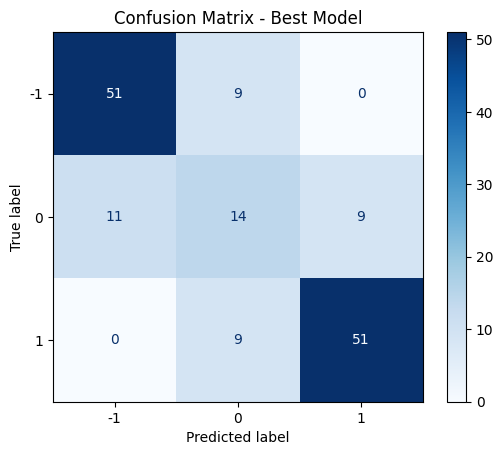

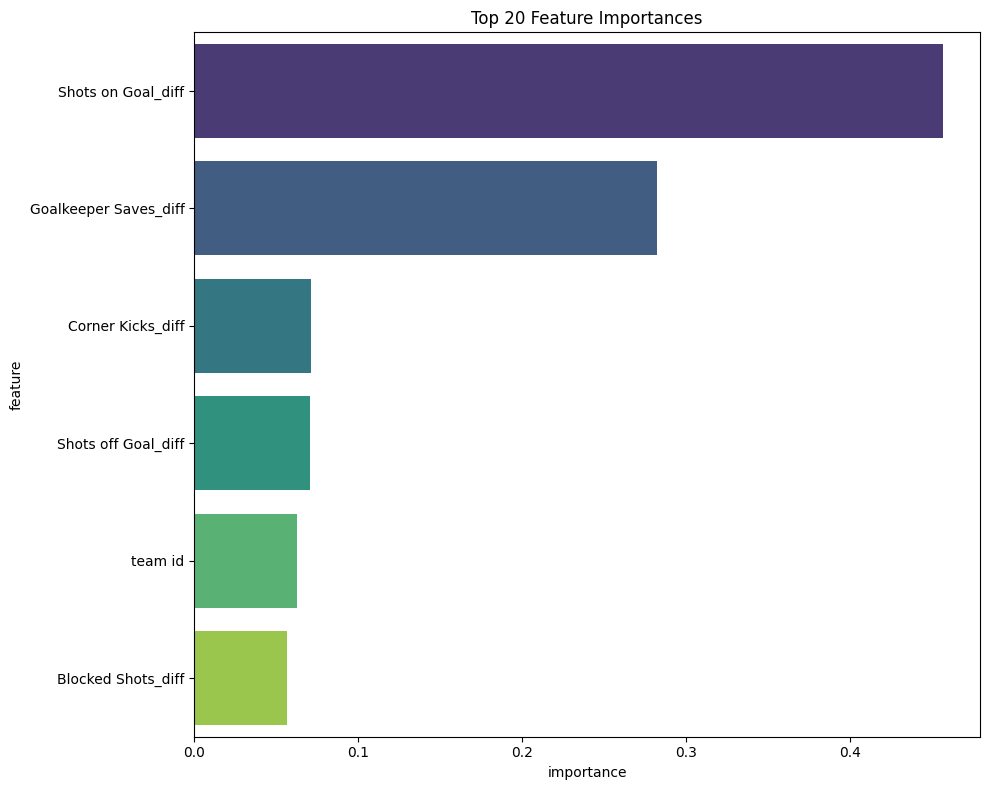

✅ Model training completed successfully!


In [ ]:
print("Training models on processed data...")

if len(sample_data) > 50:  # Only train if we have enough rows
        trained_model = predictor.train_models(sample_data)
        print("✅ Model training completed successfully!")
else:
        print("⚠️ Not enough rows for model training")


In [ ]:
import joblib

# Save model
joblib.dump(trained_model, "my_model.pkl")

# Load model later
model = joblib.load("my_model.pkl")

In [ ]:
import pandas as pd

def predict_from_dict(model, input_dict, feature_order=[
            'Shots on Goal_diff', 'Shots off Goal_diff',
            'Corner Kicks_diff','Blocked Shots_diff','team id',
            'Goalkeeper Saves_diff'
        ]):
    """
    Make predictions from a dictionary input.

    model: trained ML model
    input_dict: dict of features (e.g. {"age": 25, "height": 175, ...})
    feature_order: list of feature names in the same order used during training
                   (optional, but safer to avoid column mix-up)
    """
    # If no feature order is given, use dict keys order
    if feature_order:
        data = [[input_dict[feat] for feat in feature_order]]
        df = pd.DataFrame(data, columns=feature_order)
    else:
        df = pd.DataFrame([input_dict])

    # Predict
    return model.predict(df)[0]   # return single value


In [ ]:
def process_match_data(self, file_path: str, model, interval_minutes: int = 5,
                       timestamp_col="timestamp", tweet_col="tweet"):
    """
    Process match data from CSV with match-time timestamps (e.g., "00:05"),
    display summary + stats every N minutes.
    """
    try:
        # Load CSV
        df = pd.read_csv(file_path)

        # Convert "MM:SS" strings into total seconds, then minutes
        df["minute"] = df[timestamp_col].astype(str).apply(lambda x: int(x.split(":")[0]))
        df = df.sort_values("minute").reset_index(drop=True)

        print(f"Processing {len(df)} tweets from {file_path}")

        max_minute = df["minute"].max()

        # Loop over 5-min windows
        for start in range(0, max_minute+1, interval_minutes):
            end = start + interval_minutes
            mask = (df["minute"] >= start) & (df["minute"] < end)
            tweets_batch = df.loc[mask, tweet_col].dropna().astype(str).tolist()

            if tweets_batch:
                events = self.extract_events_from_text(tweets_batch)
                self.update_events(events)

                summary = self.generate_summary()
                print(f"\nInterval {start}-{end} minutes")
                print(" Summary:", summary["summary"])
                print(" Stats:", summary["stats"])

                # Prediction
                x = summary["stats"]
                y = predict_from_dict(model, x)
                print(" Prediction:", y)

    except FileNotFoundError:
        print(f"File {file_path} not found.")

In [ ]:
tracker = LiveMatchTracker()
tracker.process_match_data("tweets.csv", model,
                           timestamp_col="timestamp", tweet_col="tweet", interval_minutes=5)

Processing 1074 tweets from tweets.csv

Interval 00:01 - 00:06
 Summary: No major events in this period.
 Stats: {'Corner Kicks_diff': 0, 'team id': 0, 'Blocked Shots_diff': 0, 'Shots on Goal_diff': 0, 'Shots off Goal_diff': 0, 'Goalkeeper Saves_diff': 0}
 Prediction: 0

Interval 00:06 - 00:11
 Summary: No major events in this period.
 Stats: {'Corner Kicks_diff': 0, 'team id': 0, 'Blocked Shots_diff': 0, 'Shots on Goal_diff': 0, 'Shots off Goal_diff': 0, 'Goalkeeper Saves_diff': 0}
 Prediction: 0

Interval 00:11 - 00:16
 Summary: No major events in this period.
 Stats: {'Corner Kicks_diff': 0, 'team id': 0, 'Blocked Shots_diff': 0, 'Shots on Goal_diff': 0, 'Shots off Goal_diff': 0, 'Goalkeeper Saves_diff': 0}
 Prediction: 0

Interval 00:16 - 00:21
 Summary: No major events.
 Stats: {'Corner Kicks_diff': 0, 'team id': 0, 'Blocked Shots_diff': 0, 'Shots on Goal_diff': 0, 'Shots off Goal_diff': 0, 'Goalkeeper Saves_diff': 0}
 Prediction: 0

Interval 00:21 - 00:26
 Summary: No major event